## Can we fit the remaining variance?
### Using W-S as the input for the RP transform


In [589]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [590]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Create common masks and functions

In [591]:
# def mask_nonan(df,nan_col_list):
#     mask = df.notnull()
#     return mask.loc[:,nan_col_list].all(axis=1)

# def mask_noclay(df,nan_col_list):
#     return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

# def mask_SP_only(df,nan_col_list):
#     return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

# def mask_stds(df,nstds,testcol,nan_col_list):
#     pop = df.loc[mask_nonan(df,nan_col_list),testcol]
#     return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
#                            pop > np.mean(pop)-nstds*np.std(pop))
# def mask_wherescreen(df,nan_col_list):
#     return  mask_nonan(df[df.screen.notnull()],nan_cols)
def export_tree(export_dir,reg,max_depth,predictors,prefix='BagTree_',**kwargs):
    #Export graphs
    from sklearn import tree
    fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
    tree.export_graphviz(reg,out_file=export_dir.joinpath('tree.dot').as_posix(),filled=True,rounded=True,**kwargs)
    call(['dot', '-Tpng', figdir.joinpath('tree.dot').as_posix(), '-o',
    export_dir.joinpath(prefix+fig_suffix).as_posix(), '-Gdpi=150'])
    return

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def rho2tds_est(rho,m=.692826,b=-220.28):
    return 1e4*m/rho + b

def cond2rho(cond):
    return 1e4/cond
    
def nested_logicals(df,list_of_conditions,func=np.logical_and):
    '''
    Convenience function to nest numpy logical functions
        Input: 
            df
            list_of_conditions
            func: numpy function to be applied
        Output:
            logical mask for the given dataframe
        '''
    out = np.ones(len(list_of_conditions[0]),dtype=bool)
    for i in range(len(list_of_conditions)):
        out = func(out,list_of_conditions[i])
    return out

def interpIntervals(df,interp_cols,group_cols=['Well','Year'],dept_col='DEPT',interval=.5):
    '''
    Interpolates numerical values to a specified resolution (interval) 
    Meant for use with depth-registered well data
        Input:
            df: DataFrame
            interp_cols: list
            group_cols: list
            dept_col: str
            interval: numeric
        Output:
            DataFrame with interpolated rows
    '''
    frames = []
    for key,group in df.groupby(by=group_cols):

        all_cols = group.columns
        dup_cols=[col for col in all_cols if (col not in (interp_cols+[dept_col]))]

        #interpolation
        x_eval = np.arange(group.loc[:,dept_col].values[0],group.loc[:,dept_col].values[-1]+interval,interval)
        xp = group.loc[:,dept_col].values
        y_eval={}
        for col in interp_cols:
            yp = group.loc[:,col].values
            y_eval[col]=np.interp(x_eval,xp,yp)

        #create new DF
        df_out = pd.DataFrame(columns=all_cols)
        df_out = df_out.append([df.loc[group.index[0],dup_cols]]*len(x_eval))
        for col in interp_cols:
            df_out.loc[:,col] = y_eval[col]
        df_out.loc[:,dept_col] = x_eval

        #concatenate frames
        frames.append(df_out)
    return pd.concat(frames).reset_index(drop=True)

def concat_dfs(dfs):
    dfs = [sc_df_interp,df2]
    new_dfs = []
    maxind= 0

    for df in dfs:
        df_index = df.index.values + maxind + 1
        maxind = np.max(df_index)
        df.loc[:,'new_index'] = df_index
        df.set_index('new_index',inplace=True)
        new_dfs.append(df)
    return pd.concat(new_dfs,axis=0,sort=True)

def update_df2():
    return df.reset_index().rename(columns={"level_0": "Well"})

def update_FBS(df,TDS_col,breaks=[0,3000,10000]):
    FBS = np.zeros(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    breaks = np.r_[breaks,1e10]
    for i in range(len(breaks[:-1])):
        FBS[np.logical_and(df.loc[:,TDS_col] > breaks[i], df.loc[:,TDS_col] < breaks[i+1])] = i
    return df.assign(FBS=FBS)

def bin_wiggle(vec,binsize=.1):
    return np.random.uniform(vec-binsize/2,vec+binsize/2)

# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

### Import data exported from WellProcessing.ipynb

In [592]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2()
MPWSPnames = df2.loc[df2.FRES.notnull(),'Well'].unique()
MWnames = df.index.levels[0].values

In [593]:
### Aquifer number

In [594]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

In [595]:
# df.loc['MW-4D'].loc[328:,'RILD']=np.nan
df2 = update_df2()
wellids = df2.Well.unique()
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i

df=update_FBS(df,'TDS1')
df2=update_df2()

In [687]:
from scipy import stats
def x_y_regression(xin,yin,cin,ax=None,msk=None,plotslp=True,slpname='F',kdeplot=False,plotone2one=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    if ax is None:
        f,ax = plt.subplots(1,figsize=(5,4))
    else:
        f = plt.gcf()
    if kdeplot:
        sns.kdeplot(x,y)
    plt.scatter(x,y,c=c,**kwargs)
    plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
    if plotone2one:
        l,r = plt.xlim()
#         one2one = np.linspace(x.min(),x.max())
        one2one = np.linspace(l,r)
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
        plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \nNormErr = {:.2f}%'
                 .format(slpname,slope,r_value**2,np.round(np.linalg.norm(y-x*slope)/np.linalg.norm(y)*100,1)),transform=ax.transAxes)
    else:
        plt.text(0.05,.875,'$R^2$ = {:.2f} \nNormErr = {:.2f}%'
                 .format(r_value**2,np.round(np.linalg.norm(y-x*slope)/np.linalg.norm(y)*100,1)),transform=ax.transAxes)
    return f,ax

In [276]:
def pred_ints(estimator, X, pred_mult=.10,percentile=95):
    preds = []
    for pred in estimator.estimators_:   
        preds.append(pred.predict(X))    
    preds = np.r_[preds]*pred_mult
    err_down = np.percentile(preds, (100 - percentile) / 2. ,axis=0)
    err_up = np.percentile(preds, 100 - (100 - percentile) / 2.,axis=0)
    return err_down, err_up


def make_class_weight(y_train,class_list):
    class_weight = {}
    for c in y_train.unique():
        if c in class_list:
            class_weight[c] = 10
        else:
            class_weight[c] = 1
    return class_weight

In [277]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler


def standardize(data,colnames=None,df_concat=None):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)

    if df_concat is not None:
        cols = ['scaled'+str(col) for col in colnames]
        df_decomp = pd.DataFrame(data=data_trans,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return data_decomp
    
def standardize_pca(data,pcaobj=PCA,  n_components=3,df_concat=None,**kwargs):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)


#     pca = PCA(n_components=n_components)
    pca = pcaobj(n_components=n_components,**kwargs)
    data_decomp = pca.fit_transform(data_trans)
#     data_decomp = (pca.components_ @ data_trans.T).T
#     data_decomp = pca.components_
    if df_concat is not None:
        cols = ['pca'+str(i) for i in range(n_components)]
        df_decomp = pd.DataFrame(data=data_decomp,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return pca.components_



### Import the WS-boosted data

In [533]:
##Import the WS-boosted data
df_testing =  pd.read_pickle(lasdir.joinpath('allMWs_samp'))
df_testing = update_FBS(df_testing,'TDS1',breaks=np.arange(0,40000,3000))


In [558]:
df2.columns

Index(['Well', 'DEPT', 'RILM', 'RILD', 'GR', 'SP', 'X', 'Y', 'Region', 'lith',
       'screen', 'screen_len', 'Aquifer', 'AquiferGroup', 'TDS1', 'TDS2',
       'EC1', 'EC2', 'EC1f', 'EC2f', 'TMPf1', 'TMPf2', 'FRES', 'TMP', 'FRESc',
       'ec_fresc', 'Year', 'Lith discriptor', '% sand', '16in', 'Chloride con',
       'Rw ohmm', 'F', 'Notes', 'Rw_est', 'lithnum', 'lithnum_red',
       'lithnum_bin', 'C', 'G', 'M', 'S', 'Cb', 'Sb', 'Cb_a', 'Sb_a', 'Cb_b',
       'Sb_b', 'lith_above', 'lith_below', 'lithnum_bin_conv', 'logrild_conv',
       'logrild_conv_h', 'logrild_spline', 'logcild_spline', 'aq_groupnum',
       'aqnum', 'cond_est', 'logrild_pred_archie', 'F_WS', 'logrild_pred_ws',
       'FBS'],
      dtype='object')

### Predicting $log_{10} C_o$

In [740]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier
from sklearn.utils import resample
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 4
max_features=5
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcild'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
# predictors = ['logcild_pred_ws','logcild','X','Y','aq_groupnum','DEPT_bin']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]

# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge()
y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
#     df_test = df_testing.loc[np.logical_and(df_testing.Well==testwell,df_testing.samp==False)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
#     estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)

#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append([welldict[nam] for nam in df_test.Well])
#     errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    print('testing on',nam,
          '\tno. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',100*np.round(norm(y_test-y_predict)/norm(y_test),1),'%')

    
# y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))


y_pred_RF = np.concatenate( y_preds, axis=0 )
y_test= np.concatenate( y_tests, axis=0 )


err = (y_test-y_pred_RF)
print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(y_test)),2),'%')

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1']
testing on CX-B1 	no. samples: 3001 	test size: 120 	NormErr: 130.0 %
testing on CX-B2 	no. samples: 3041 	test size: 80 	NormErr: 60.0 %
testing on CX-B4 	no. samples: 3021 	test size: 100 	NormErr: 60.0 %
testing on MDW-1 	no. samples: 3041 	test size: 80 	NormErr: 80.0 %
testing on ML-1 	no. samples: 3091 	test size: 30 	NormErr: 100.0 %
testing on ML-2 	no. samples: 3081 	test size: 40 	NormErr: 20.0 %
testing on ML-3 	no. samples: 3081 	test size: 40 	NormErr: 20.0 %
testing on ML-4 	no. samples: 3081 	test size: 40 	NormErr: 30.0 %
testing on ML-6 	no. samples: 3081 	test size: 40 	NormErr: 50.0 %
testing on MW-1D 	no. samples: 2801 	test size: 320 	NormErr: 60.0 %
testing on MW-4D 	no. samples: 2705 	test size: 416 	NormErr: 40.0 %
testing on MW-5D 	no. samples: 2621 	test size: 500 	NormErr: 10.0 %
testing on MW-6D 	no. 

In [718]:
df_testing = df_testing.assign(logcild_pred_RF=y_pred_RF)
mean_est= np.zeros(len(df_testing))
ind1=0
for nam in df_testing.Well.unique():
    ind= np.arange(ind1,ind1+len(df_testing.loc[df_testing.Well==nam]))
    mean_est[ind] = df_testing.loc[df_testing.Well==nam,'logcild_pred_RF'].mean()
    ind1=ind[-1]+1
df_testing = df_testing.assign(logcild_mean_est=mean_est)

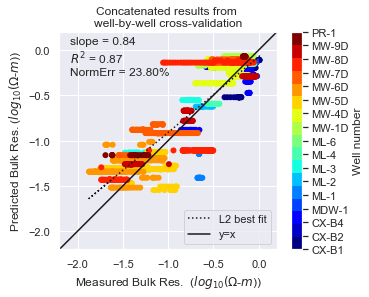

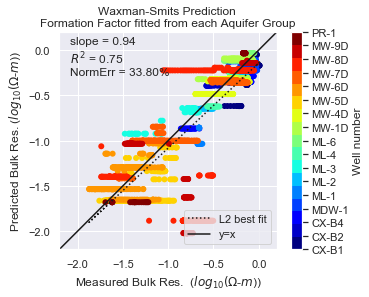

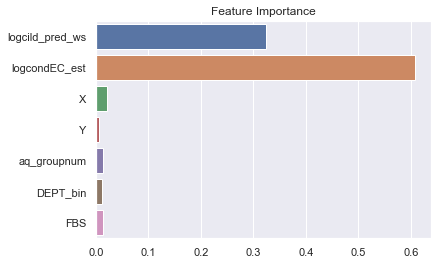

In [741]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))

# y_pred = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
# y_test=  np.log10(np.power(10,df_testing.logcondEC1f.values)/1e4)
y_pred = np.concatenate( y_preds, axis=0 )
y_test= np.concatenate( y_tests, axis=0 )

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values
y_test    = df_testing.logcild
y_pred = np.log10(1/np.power(10,df_testing.logrild_pred_ws))

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')

# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

In [719]:
df_testing.columns

Index(['Well', 'DEPT', 'RILM', 'RILD', 'GR', 'SP', 'X', 'Y', 'Region', 'lith',
       'screen', 'screen_len', 'Aquifer', 'AquiferGroup', 'TDS1', 'TDS2',
       'EC1', 'EC2', 'EC1f', 'EC2f', 'TMPf1', 'TMPf2', 'FRES', 'TMP', 'FRESc',
       'ec_fresc', 'Year', 'Lith discriptor', '% sand', '16in', 'Chloride con',
       'Rw ohmm', 'F', 'Notes', 'Rw_est', 'lithnum', 'lithnum_red',
       'lithnum_bin', 'C', 'G', 'M', 'S', 'Cb', 'Sb', 'Cb_a', 'Sb_a', 'Cb_b',
       'Sb_b', 'lith_above', 'lith_below', 'lithnum_bin_conv', 'logrild_conv',
       'logrild_conv_h', 'logrild_spline', 'logcild_spline', 'aq_groupnum',
       'aqnum', 'cond_est', 'logrild_pred_archie', 'F_WS', 'logrild_pred_ws',
       'Cw_pred_ws', 'FBS', 'DEPT_bin', 'Region_bin', 'logrhoEC1f',
       'logcondEC1f', 'logrild', 'logrild_bin', 'logcild_bin',
       'logcild_spline_bin', 'logcild', 'logcild_pred_ws', 'err_ws',
       'cild_bin', 'cond_est_bin', 'logcond_est', 'logrhoEC_est',
       'logcondEC_est', 'logrild_conv_bin',

In [720]:
df_testing = df_testing.assign(preds = np.concatenate( y_preds, axis=0 ))
# df_testing = df_testing.assign(Lconf95=np.concatenate(errs,axis=1)[0])
# df_testing = df_testing.assign(Uconf95=np.concatenate(errs,axis=1)[1])
df_testing = df_testing.assign(logrild_pred_RF=y_pred_RF)
df_testing = df_testing.assign(err=  df_testing.logrild - df_testing.logrild_pred_RF)
df_testing = df_testing.assign(err_sq=  np.power(df_testing.err,2))
df_testing = df_testing.assign(err_ws= np.abs(df_testing.logrild - df_testing.logrild_pred_ws) - np.abs(df_testing.logrild - df_testing.logrild_pred_RF))
df_testing.to_pickle(auxdir.joinpath('df_testing_xval'))
save_obj(auxdir,estimators,'estimators_xval')

### Predicting water conductivity

In [744]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge,RANSACRegressor
from sklearn.utils import resample
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 4
max_features=5
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcondEC1f'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcild','X','Y','aq_groupnum','DEPT_bin']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]

# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge()
# estimator = RANSACRegressor()
y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
#     df_test = df_testing.loc[np.logical_and(df_testing.Well==testwell,df_testing.samp==False)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
#     estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)

#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append([welldict[nam] for nam in df_test.Well])
#     errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    print('testing on',nam,
          '\tno. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',np.round(100*norm(y_test-y_predict)/norm(y_test),1),'%')

    
# y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))


y_pred_RF = np.concatenate( y_preds, axis=0 )
y_test= np.concatenate( y_tests, axis=0 )


err = (y_test-y_pred_RF)
print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(y_test)),2),'%')

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1']
testing on CX-B1 	no. samples: 3001 	test size: 120 	NormErr: 1.1 %
testing on CX-B2 	no. samples: 3041 	test size: 80 	NormErr: 1.5 %
testing on CX-B4 	no. samples: 3021 	test size: 100 	NormErr: 9.7 %
testing on MDW-1 	no. samples: 3041 	test size: 80 	NormErr: 0.5 %
testing on ML-1 	no. samples: 3091 	test size: 30 	NormErr: 23.6 %
testing on ML-2 	no. samples: 3081 	test size: 40 	NormErr: 0.9 %
testing on ML-3 	no. samples: 3081 	test size: 40 	NormErr: 13.2 %
testing on ML-4 	no. samples: 3081 	test size: 40 	NormErr: 1.0 %
testing on ML-6 	no. samples: 3081 	test size: 40 	NormErr: 0.7 %
testing on MW-1D 	no. samples: 2801 	test size: 320 	NormErr: 7.6 %
testing on MW-4D 	no. samples: 2705 	test size: 416 	NormErr: 8.3 %
testing on MW-5D 	no. samples: 2621 	test size: 500 	NormErr: 7.0 %
testing on MW-6D 	no. samples: 282

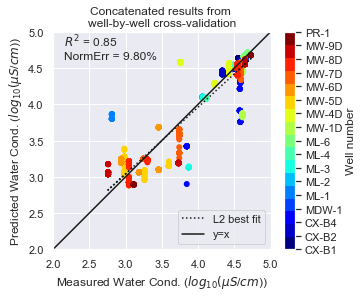

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log10


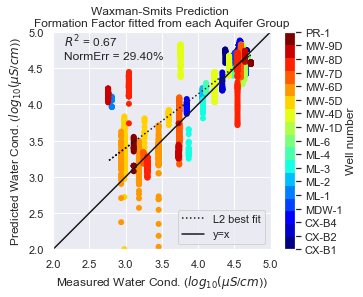

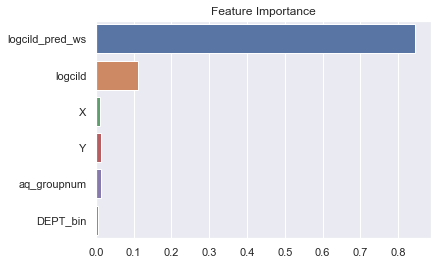

In [745]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))

# y_pred = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
# y_test=  np.log10(np.power(10,df_testing.logcondEC1f.values)/1e4)
y_pred = np.concatenate( y_preds, axis=0 )
y_test=  df_testing.logcondEC1f.values

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(2,5)
plt.ylim(2,5)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                      plotslp=False,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.ylabel('Predicted Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values

y_test = df_testing.logcondEC1f.values
y_pred = np.log10(df_testing.Cw_pred_ws.values*1e4)

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(2,5)
plt.ylim(2,5)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,plotslp=False,
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.ylabel('Predicted Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])

# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

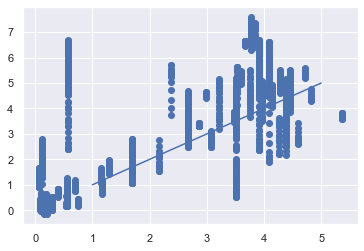

In [628]:
plt.scatter(df_testing.EC1f/1e4,df_testing.Cw_pred_ws)
plt.plot((1,5),(1,5))

Text(0, 0.5, 'err')

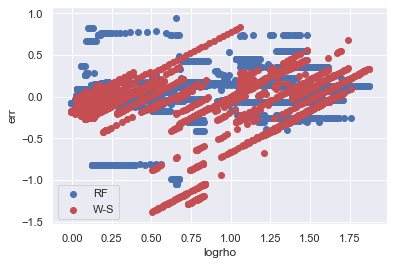

In [627]:
plt.scatter(df_testing.logrild,err,c='b',label='RF')
plt.scatter(df_testing.logrild,(df_testing.logrild-df_testing.logrild_pred_ws),c='r',label='W-S')
plt.legend()
plt.xlabel('logrho')
plt.ylabel('err')

array([-1.5       , -1.36842105, -1.23684211, -1.10526316, -0.97368421,
       -0.84210526, -0.71052632, -0.57894737, -0.44736842, -0.31578947,
       -0.18421053, -0.05263158,  0.07894737,  0.21052632,  0.34210526,
        0.47368421,  0.60526316,  0.73684211,  0.86842105,  1.        ])

Text(0, 0.5, 'Probability density')

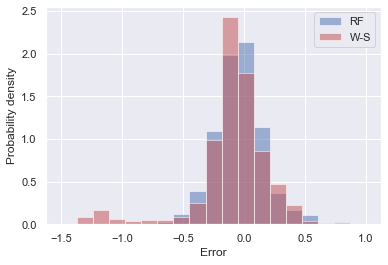

In [723]:
bins=np.linspace(-1.5,1,20)
h,bins,patch = plt.hist(err,color='b',density=True,alpha=.5,label='RF',bins=bins)
h,bins,patch = plt.hist((df_testing.logrild-df_testing.logrild_pred_ws),color='r',density=True,alpha=.5,label='W-S',bins=bins)

plt.legend()
plt.xlabel('Error')
plt.ylabel('Probability density')